# Unsupervised Learning with Linear Algebra 
## Kate Kenny 
### CS 0451

In this blog post, we will be exploring unsupervised learning through two examples.  We will be working with Singular Value Decomposition (SVD) to do image compression and with Spectral Community Detection to deal with clusters of data. As a result, this blog post is broken into two sections.

## Singular Value Decompostion
The SVD of a matrix $\mathbf{A} \in \mathbb{R}^{mxn}$ is as follows. 

$\mathbf{A = UDV}^T$

where $\mathbf{D}$ is a diagonal matrix and the matrices $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices. The entries of $\mathbf{D}$, $\sigma_i$, give some measure of how large $\textbf{A}$ is. We can approximate the matrix $\textbf{A}$ using a representation that only considers the first $k$ columns of $\textbf{U}$, $k$ values in $\textbf{D}$ and the first $k$ rows of $\textbf{V}$. 

In this post, we are going to use SVD to construct approximations of a greyscale image using different values of $k$.

### Choosing an image

First, let's choose an RGB image and convert it to greyscale. I am selecting a picture of a Nova Scotia Duck Tolling Retriever. 

[Text(0.5, 1.0, 'greyscale')]

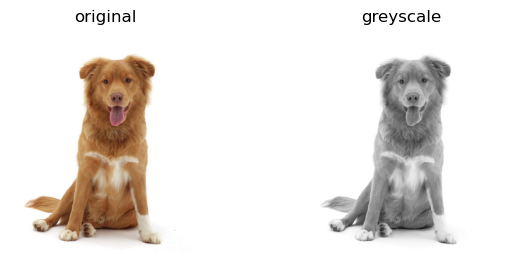

In [16]:
import PIL
import urllib

def read_image(url):
    return np.array(PIL.Image.open(urllib.request.urlopen(url)))

url = "https://images.fineartamerica.com/images/artworkimages/mediumlarge/3/nova-scotia-duck-tolling-retriever-dog-warren-photographic.jpg"
img = read_image(url)

fig, axarr = plt.subplots(1, 2, figsize = (7, 3))

def to_greyscale(im):
    return 1 - np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])

grey_img = to_greyscale(img)

axarr[0].imshow(img)
axarr[0].axis("off")
axarr[0].set(title = "original")

axarr[1].imshow(grey_img, cmap = "Greys")
axarr[1].axis("off")
axarr[1].set(title = "greyscale")


## Implementation
Now, our image is a very large matrix. So we can implement SVD to approximate the picture!

We are going to write a few methods in this post included svd_reconstruct() which will reconstruct an image using a given value $k$ and svd_experiment() which will reconstruct an image for a variety of $k$ values and determine the percentage of the original image's storage needed for each reconstruction. Additionally, we will need to write some methods to view and compare our images and reconstructions. 

In [ ]:
def compare_images(self, A, A_):
    #plots and labels original/reconstructed images

        fig, axarr = plt.subplots(1, 2, figsize = (7, 3))

        axarr[0].imshow(A, cmap = "Greys")
        axarr[0].axis("off")
        axarr[0].set(title = "original image")

        axarr[1].imshow(A_, cmap = "Greys")
        axarr[1].axis("off")
        axarr[1].set(title = "reconstructed image")

### Reconstructing our original image

Let's implement the svd_reconstruct() function that allows us to specify $k$ and perform SVD reconstruction on an image using that value. 

In [91]:
from matplotlib import pyplot as plt
import numpy as np

def svd_reconstruct(img, k): 
        #reconstructs img from SVD using k values

        A = img
       
        U, sigma, V = np.linalg.svd(A)
        
        #construct diagonal matrix D whose entries are entires of sigma
        D = np.zeros_like(A,dtype=float) # matrix of zeros of same shape as A
        D[:min(A.shape),:min(A.shape)] = np.diag(sigma)
        
        #index first k rows/entries/columns of U, D, and V respectively
        U_ = U[:,:k]
        D_ = D[:k, :k]
        V_ = V[:k, :]

        A_ = U_ @ D_ @ V_
        return A_
    

Now that we have our reconstruct function, let's try it for $k=5$ on the image selected above.

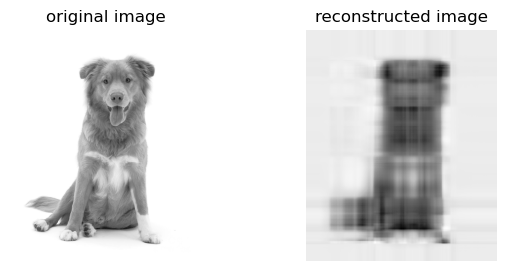

In [92]:
compare_images(grey_img, svd_reconstruct(grey_img, 5))

This is not a great approximation, but we can start to see our image taking shape even with a $k$ value as low as 5. So now let's implement our experimentation function and see how different $k$ values perform when reconstructing our image. 

### Experimentation

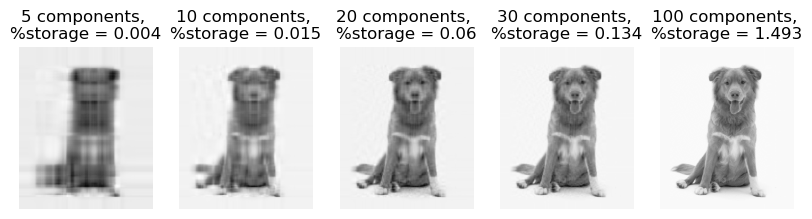

In [93]:
def svd_experiment(img): 
    fig, axarr = plt.subplots(1, 5, figsize = (10, 3))

    k_arr = np.array([5, 10, 20, 30, 100])
    count = 0
    
    for k in k_arr: 
        storage = round((k*k) / (img.shape[0]*img.shape[1]) * 100, 3)
        axarr[count].imshow(svd_reconstruct(img, k), cmap = "Greys")
        axarr[count].axis("off")
        axarr[count].set(title = str(k) + " components, \n%storage = " + str(storage))
        
        count+= 1
    
svd_experiment(grey_img)

It is striking how low the percentage of storage needed to store these images is. Part of the reason for this could be the image we are using in our experiment, which has a shape of (900, 744) and consequently requires a large number of pixels for storage itself. This really shows the utility of our reconstructed images as there is no difference to the naked high with 100 components yet the storage demands are vastly different. 

## Spectral Community Detection 

Next, we are going to explore unsupervised learning in the context of Laplacian spectral clustering. Specifically, we will be looking at a graph that represents a social network, specifically a karate club. Below is the network. 

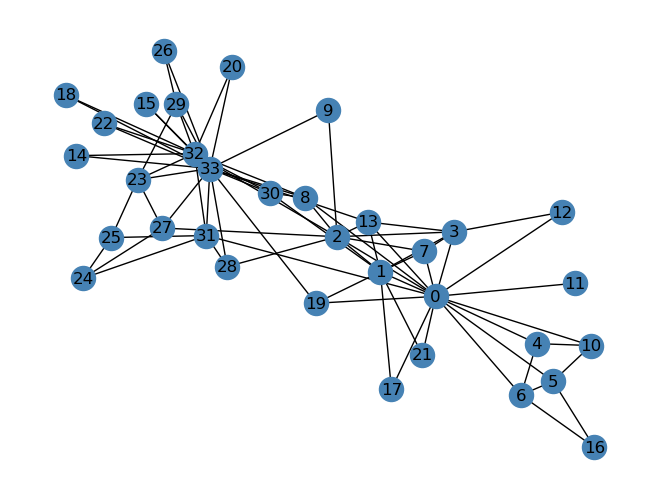

In [112]:
import networkx as nx
G = nx.karate_club_graph()
layout = nx.fruchterman_reingold_layout(G)
nx.draw(G, layout, with_labels=True, node_color = "steelblue")

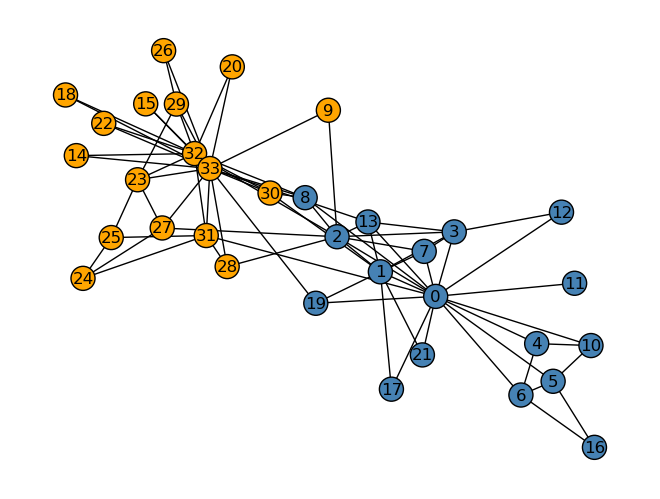

In [113]:
clubs = nx.get_node_attributes(G, "club")

nx.draw(G, layout,
        with_labels=True, 
        node_color = ["orange" if clubs[i] == "Officer" else "steelblue" for i in G.nodes()],
        edgecolors = "black" # confusingly, this is the color of node borders, not of edges
        ) 

In [191]:

def spectral_clustering(G): 
    #define adjacency matrix A
    A = nx.adjacency_matrix(G).toarray()
    
    #construct diagonal matrix D whose entries are sum of respective row in A
    diag = np.sum(A, axis = 1)
    D = np.diag(diag)
    
    #calculate L 
    L = (np.linalg.inv(D))@(A - D)
    
    #compute eigenvalues and corresponding eigenvectors
    eigs, eig_vecs = np.linalg.eig(L)
    
    #delete min eigenvalue and corresponding eigenvector
    eigs2 = np.delete(eigs, np.argmin(eigs))
    eig_vecs2 = np.delete(eig_vecs, np.argmin(eigs), 0)
    
    z = eig_vecs[np.argmin(eigs2)]
    return z

#create labels based on z and plot graph

clubs = nx.get_node_attributes(G, "club")

def make_attributes(G, z): 
    labels = {}
    for i in G.nodes(): 
        labels[i] = "group2" if z[i] != z[0] else "group1"
    return nx.set_node_attributes(G, labels)
    
print(make_attributes(G, spectral_clustering(G)))

colors = ["red" if z[i] != z[j] else "grey" for i, j in G.edges()]

nx.draw(G, layout,
        with_labels=True, 
        node_color = ["orange" if clubs[i] == "Officer" else "steelblue" for i in G.nodes()],
        edgecolors = "black" # confusingly, this is the color of node borders, not of edges
        ) 

nx.draw(G, layout,
        with_labels=True, 
        node_color = spectral_clustering(G),
        edgecolors = "black" # confusingly, this is the color of node borders, not of edges
        ) 

ValueError: dictionary update sequence element #0 has length 1; 2 is required

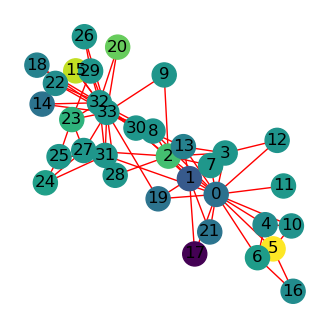

In [186]:
def plot_graph(G, z = None, ax = None, show_edge_cuts = True):
    if z is None:
        nx.draw(G, layout, alpha = .4, node_color = "grey", node_size = 20, ax = ax)
    else: 
        if show_edge_cuts:
            colors = ["red" if z[i] != z[j] else "grey" for i, j in G.edges()]
            widths = [2 if z[i] != z[j] else 1 for i, j in G.edges()]
        else:
            colors = "black"
            widths = 1
        
        nx.draw(G, layout, with_labels=True, node_color = z, edge_color = colors)
        
fig, ax = plt.subplots(figsize = (4, 4))

plot_graph(G, z=spectral_clustering(G))